<a href="https://colab.research.google.com/github/wilmarpc/Celonis-ML-Python/blob/main/ML_Late_Payment_Karen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --extra-index-url=https://pypi.celonis.cloud/ pycelonis=="2.0.1"

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import DataFrame
 


In [2]:
url = "https://empresas-cmpc.us-1.celonis.cloud/"

# Application Key: este es el Token que sirve para 
api_token = "MTlkYzJhZmEtNDc5Mi00YTM3LTg5MjEtNTY0YjhkMDA1YzFjOnJQSExxT0RzWENoUm5ITEJwV2FZcmVjOGNnbDF0NDM4d1lWa1FTc3ZsYTdT"
key_type = "APP_KEY"

from pycelonis import get_celonis
celonis = get_celonis(base_url=url, api_token=api_token, key_type=key_type)

# Busqueda de Data Pool
data_pool_id = '4b4b91a0-b397-4b41-9a02-85598e47f874'
data_pool = celonis.data_integration.get_data_pool(data_pool_id)
data_pool

# Busqueda de Data Model
data_model = data_pool.get_data_model('51b22ede-2d5f-49b8-90b9-a2a884a8757a')
data_model

# Importación de modulos necesarios
from pycelonis.pql import PQL, PQLColumn, PQLFilter, OrderByColumn
query = PQL(distinct=False, limit=None, offset=None)
query

PQL(columns=[], filters=[], order_by_columns=[], distinct=False, limit=None, offset=None)

0it [00:00, ?it/s]

(13, 2)


<AxesSubplot:xlabel='Due_Date'>

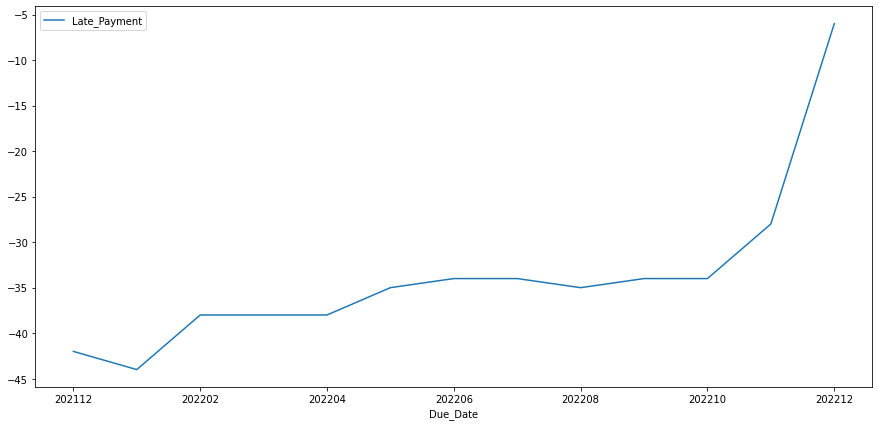

In [3]:
# Extracción de columnas y tablas
#query += PQLColumn(name="Due_Date", query=""" CONCAT(YEAR(BSEG.ZFBDT), '-' ,MONTH(BSEG.ZFBDT)) """)
query += PQLColumn(name="Due_Date", query=""" CONCAT(YEAR(BSEG.ZFBDT), TO_STRING(BSEG.ZFBDT, FORMAT('%m'))) """)
# query += PQLColumn(name="Invoice_Amount", query=""" ROUND("BSEG"."WRBTR") """)
# query += PQLColumn(name="Vendor_Name", query=""" "LFA1"."LIFNR" """)
query += PQLColumn(name="Late_Payment", query=""" ROUND(AVG(DATEDIFF(DD, BSEG.AUGDT, BSEG.ZFBDT))) """)
query
# poner filtros

query += PQLFilter(query=""" FILTER YEAR(BSEG.ZFBDT) BETWEEN 2020 AND 2023; """)
# query += PQLFilter(query=""" FILTER "BKPF"."BUKRS" = '104'; """)
query += PQLFilter(query=""" FILTER "LFA1"."LIFNR" = '0000010558'; """)
#'0000400585','0000010549','0000010421','0000088717','0000104299','0000325241','0000010489','0000010315','0000103518')
query += PQLFilter(query=""" FILTER DATEDIFF(DD, "BSEG"."AUGDT", "BSEG"."ZFBDT") IS NOT NULL; """)
# poner orden a la consulta
# query += OrderByColumn(query=""" "ACTIVITIES"."EVENTTIME" """)
# query += OrderByColumn(query=""" "ACTIVITIES"."_SORTING" """)

query.limit = 100000

# Volver query extraida de celonis a DataFrame
result_df = data_model.export_data_frame(query)
print(result_df.shape)
result_df.head()

#df=pd.read_csv('ventas_mes_2016_2018_mod datos fechas NCRs y CLIs licitacion SIN TABLETS SIN CODERE PUNTUAL.csv')
#df.head()

df = result_df

# Updating the header
df.columns=["Due_Date","Late_Payment"]
df.head()
df.describe()
df.set_index('Due_Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

In [4]:
df.head()

,Late_Payment
Due_Date,
202112,-42
202201,-44
202202,-38
202203,-38
202204,-38


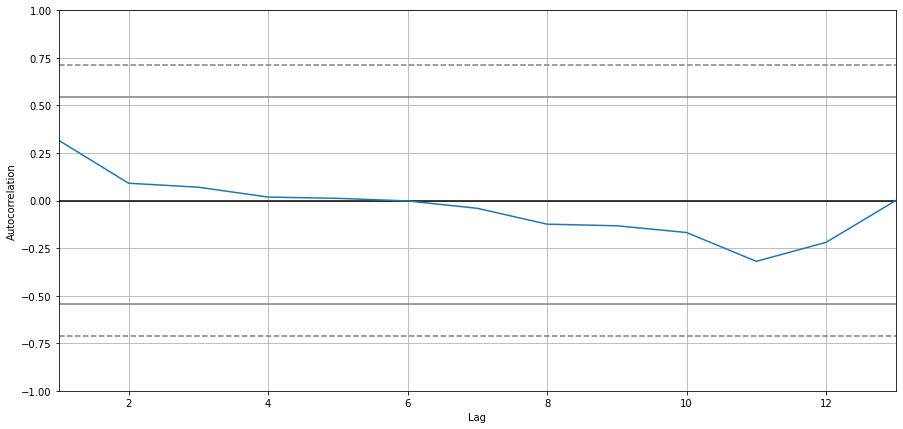

In [5]:
autocorrelation_plot(df)
pyplot.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


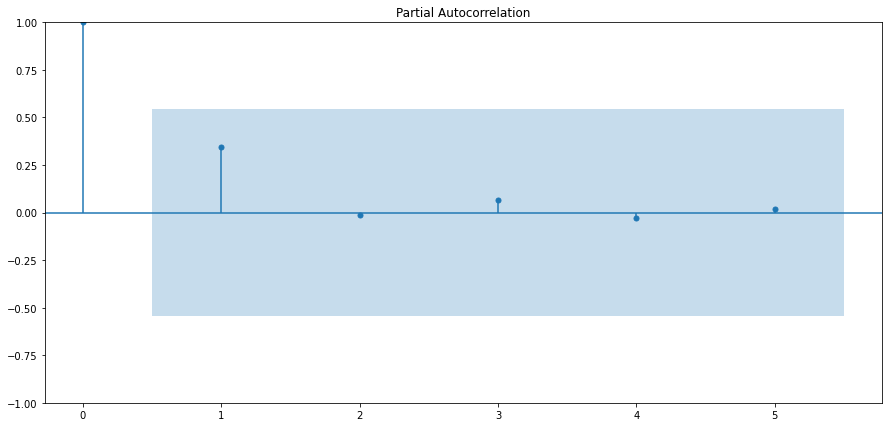

In [6]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
# series = read_csv('ventas_mes_2016_2018_mod datos fechas NCRs y CLIs licitacion SIN TABLETS SIN CODERE PUNTUAL.csv', header=0, index_col=0)
series = result_df


plot_pacf(series, lags=5)
pyplot.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
# test_result=adfuller(df['Sales'])

test_result=adfuller(df['Late_Payment'])

In [9]:
def adfuller_test(sales):
  result = adfuller(sales)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
  for value,label in zip(result,labels):
    print(label+' : '+str(value) )

  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Late_Payment'])

ADF Test Statistic : 1.8603475979687334
p-value : 0.9984614868788124
#Lags Used : 0
Number of Observations : 12
weak evidence against null hypothesis,indicating it is non-stationary 


In [10]:
!pip install pmdarima
from pmdarima.arima import auto_arima
#stepwise_fit = auto_arima(df['Sales'], trace=True,
stepwise_fit = auto_arima(df['Late_Payment'], trace=True,
suppress_warnings=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.914, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.847, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.425, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.982 seconds


In [11]:
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# model=ARIMA(df['Sales'],order=(0,1,1))
#model=ARIMA(df['Late_Payment'],order=(0,1,1))

model = sm.tsa.arima.ARIMA(df['Late_Payment'], order=(0,1,1))
#result = model.fit()

model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Late_Payment   No. Observations:                   13
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -38.245
Date:                Tue, 07 Mar 2023   AIC                             80.490
Time:                        21:40:51   BIC                             81.459
Sample:                             0   HQIC                            80.130
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9993    205.010      0.005      0.996    -400.813     402.812
sigma2        27.7525   5689.081      0.005      0.996   -1.11e+04    1.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 5.01
Prob(Q):                              0.79   Prob(JB):                         0.08
Heteroskedasticity (H):               4.45   Skew:                             1.40
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
#model_fit.plot_predict()


plt.show(model_fit)

In [13]:
model_fit.fittedvalues

Due_Date
202112     0.000000
202201   -42.001165
202202   -44.999431
202203   -33.333693
202204   -41.499736
202205   -35.200210
202206   -34.833159
202207   -33.285864
202208   -34.624868
202209   -35.333450
202210   -32.799897
202211   -35.091001
202212   -21.499928
dtype: float64

# Cargamos las predicciones a un DataFrame para luego llevarlo a Celonis

In [ ]:
residuals = pd.DataFrame(data=model_fit.resid)
residuals

In [ ]:
# student_df_2 = pd.DataFrame(student_dict)
# student_df_2.columns = ["Student_ID", "First_Name", "Average_Grade"]

#residuals = pd.DataFrame(model_fit.resid)
#residuals.columns = ["Periodos","Dias" ]
# student_df_3.columns = student_df_3.columns.str.replace("id", "ID")
#residuals.columns = residuals.columns.str.replace("Due_Date", "Periodo")
#residuals.columns = residuals.columns.str.replace("0", "Dias")

# student_df_4.set_axis(["A", "B", "C"], axis="columns", inplace=True)
#residuals.set_axis(["Periodos", "Dias"], axis="columns", inplace=True)
#residuals



In [15]:
residuals.columns=["dias"]
residuals


,dias
Due_Date,
202112,-42.000000
202201,-1.998835
202202,6.999431
202203,-4.666307
202204,3.499736
202205,0.200210
202206,0.833159
202207,-0.714136
202208,-0.375132


In [17]:
# Grabar la tabla con RESIDUALS
data_pool.create_table(residuals, table_name="ML_Prediccion_0000010558", drop_if_exists=True,force=True)

# Grabar la tabla con FITTEDVALUES
#celo = pd.DataFrame(data=model_fit.fittedvalues)
#celo.columns=["Due_Date,Late_Payment"]
#data_pool.create_table(celo, table_name="ML_Prediccion_0000010558", drop_if_exists=True)

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

DataPoolTable(name='ML_Prediccion_0000010558', data_source_id=None, columns=[], schema_name='4b4b91a0-b397-4b41-9a02-85598e47f874', data_pool_id='4b4b91a0-b397-4b41-9a02-85598e47f874')

In [ ]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

In [ ]:
fig = model_fit.plot_predict(start='2018-01-01', end='2019-03-01')
fig.show()

In [ ]:
residuals.plot(kind='kde')
pyplot.show()

In [ ]:
print(residuals.describe())

In [ ]:
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#import itertools
#p=d=q=range(0,9)
#pdq = list(itertools.product(p,d,q))
#pdq

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')
#for param in pdq:
 #   try:
  #      model_arima = ARIMA(train,order=param)
   #     model_arima_fit = model_arima.fit()
    #    print(param,model_arima_fit.aic)
    #except:
     #   continue

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 2),seasonal_order=(0,0,0,0))
results = model.fit()
df['forecast']=results.predict(start=10,end=80,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))